In [1]:
import pandas as pd
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, GlobalAveragePooling2D, Activation, Dropout
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
input_shape = (512, 512, 3)
input_size = (512, 512)
np.random.seed(42)
tf.random.set_seed(42)

def load_dataset(path, split=0.1):
    images = []
    bboxes = []
    df = pd.read_csv(os.path.join(path, "bbox.csv"))
    for index, row in df.iterrows():
        name = row["name"]
        x1 = int(row["x1"])
        y1 = int(row["y1"])
        x2 = int(row["x2"])
        y2 = int(row["y2"])
        image = os.path.join(path, "images", name)
        bbox = [x1, y1, x2, y2]
        images.append(image)
        bboxes.append(bbox)
    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(bboxes, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image_bbox(path, bbox):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    h, w, _ = image.shape
    image = cv2.resize(image, input_size)
    image = (image - 127.5) / 127.5 # Normalize into [-1, +1]
    image = image.astype(np.float32)
    x1, y1, x2, y2 = bbox
    norm_x1 = float(x1/w)
    norm_y1 = float(y1/h)
    norm_x2 = float(x2/w)
    norm_y2 = float(y2/h)
    norm_bbox = np.array([norm_x1, norm_y1, norm_x2, norm_y2], dtype=np.float32)
    return image, norm_bbox

def parse(x, y):
    x, y = tf.numpy_function(read_image_bbox, [x, y], [tf.float32, tf.float32])
    x.set_shape(input_shape)
    y.set_shape([4])
    return x, y
 
def tf_dataset(images, bboxes, batch=8):
    ds = tf.data.Dataset.from_tensor_slices((images, bboxes))
    ds = ds.map(parse).batch(batch).prefetch(10)
    return ds

def cal_iou(y_true, y_pred):
    x1 = max(y_true[0], y_pred[0])
    y1 = max(y_true[1], y_pred[1])
    x2 = min(y_true[2], y_pred[2])
    y2 = min(y_true[3], y_pred[3])
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    true_area = (y_true[2] - y_true[0] + 1) * (y_true[3] - y_true[1] + 1)
    bbox_area = (y_pred[2] - y_pred[0] + 1) * (y_pred[3] - y_pred[1] + 1)
    iou = intersection_area / float(true_area + bbox_area - intersection_area)
    return iou

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset("/kaggle/input/human-detection")
train_ds = tf_dataset(train_x, train_y, batch=16)
valid_ds = tf_dataset(valid_x, valid_y, batch=16)
inputs = Input(input_shape)
backbone = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs,
    alpha=1.0
)
backbone.trainable = False
output = Conv2D(256, kernel_size=1, padding="same")(backbone.output)
output = BatchNormalization()(output)
output = Activation("relu")(output)
output = GlobalAveragePooling2D()(output)
output = Dropout(0.5)(output)
output = Dense(4, activation="sigmoid")(output)
model = Model(inputs, output)
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
)
model.fit(
    train_ds,
    epochs=2,
    validation_data=valid_ds,
)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/2
43/43 [==============================] - 149s 3s/step - loss: 0.5234 - val_loss: 0.4669
Epoch 2/2
43/43 [==============================] - 143s 3s/step - loss: 0.4542 - val_loss: 0.4582


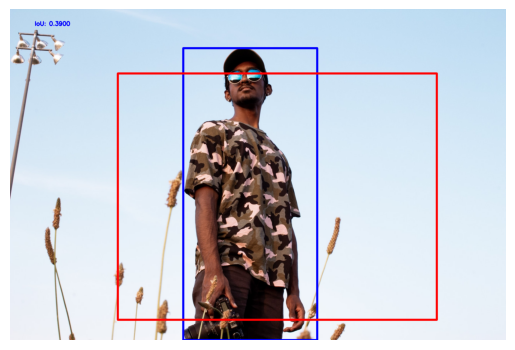

In [3]:
image, true_bbox = test_x[3], test_y[3] # Pick an image from Test set
image = cv2.imread(image, cv2.IMREAD_COLOR) 
true_x1, true_y1, true_x2, true_y2 = true_bbox 
image_resize = cv2.resize(image, input_size)
image_resize = np.expand_dims(image_resize, axis=0)
output = model(image_resize)
pred_bbox = output.numpy()[0]

# Plot Image
pred_x1 = int(pred_bbox[0] * image.shape[1])
pred_y1 = int(pred_bbox[1] * image.shape[0])
pred_x2 = int(pred_bbox[2] * image.shape[1])
pred_y2 = int(pred_bbox[3] * image.shape[0])
image = cv2.rectangle(image, (true_x1, true_y1), (true_x2, true_y2), (255, 0, 0), 10) ## BLUE
image = cv2.rectangle(image, (pred_x1, pred_y1), (pred_x2, pred_y2), (0, 0, 255), 10) ## RED
x = cv2.resize(image, input_size)
x = (x - 127.5) / 127.5
x = np.expand_dims(x, axis=0)
x = int(image.shape[1] * 0.05)
y = int(image.shape[0] * 0.05)
font_size = int(image.shape[0] * 0.001)
iou = cal_iou(true_bbox, [pred_x1, pred_y1, pred_x2, pred_y2])
cv2.putText(image, f"IoU: {iou:.4f}", (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 0, 0), 3)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()